In [2]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
from sklearn.cluster import KMeans
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import xgboost
import re
import scipy
import hyperopt

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [4]:
train_df.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9   ...        cont6  \
0   1    A    B    A    B    A    A    A    A    B   ...     0.718367   
1   2    A    B    A    A    A    A    A    A    B   ...     0.438917   
2   5    A    B    A    A    B    A    A    A    B   ...     0.289648   
3  10    B    B    A    B    A    A    A    A    B   ...     0.440945   
4  11    A    B    A    B    A    A    A    A    B   ...     0.178193   

      cont7    cont8    cont9   cont10    cont11    cont12    cont13  \
0  0.335060  0.30260  0.67135  0.83510  0.569745  0.594646  0.822493   
1  0.436585  0.60087  0.35127  0.43919  0.338312  0.366307  0.611431   
2  0.315545  0.27320  0.26076  0.32446  0.381398  0.373424  0.195709   
3  0.391128  0.31796  0.32128  0.44467  0.327915  0.321570  0.605077   
4  0.247408  0.24564  0.22089  0.21230  0.204687  0.202213  0.246011   

     cont14     loss  
0  0.714843  2213.18  
1  0.304496  1283.60  
2  0.774425  3005.09  
3  0.602642   939.85  
4  0.432606  2763.85  

[5 rows x 132 columns]

In [6]:
print(list(train_df.columns))

['id', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9', 'cat10', 'cat11', 'cat12', 'cat13', 'cat14', 'cat15', 'cat16', 'cat17', 'cat18', 'cat19', 'cat20', 'cat21', 'cat22', 'cat23', 'cat24', 'cat25', 'cat26', 'cat27', 'cat28', 'cat29', 'cat30', 'cat31', 'cat32', 'cat33', 'cat34', 'cat35', 'cat36', 'cat37', 'cat38', 'cat39', 'cat40', 'cat41', 'cat42', 'cat43', 'cat44', 'cat45', 'cat46', 'cat47', 'cat48', 'cat49', 'cat50', 'cat51', 'cat52', 'cat53', 'cat54', 'cat55', 'cat56', 'cat57', 'cat58', 'cat59', 'cat60', 'cat61', 'cat62', 'cat63', 'cat64', 'cat65', 'cat66', 'cat67', 'cat68', 'cat69', 'cat70', 'cat71', 'cat72', 'cat73', 'cat74', 'cat75', 'cat76', 'cat77', 'cat78', 'cat79', 'cat80', 'cat81', 'cat82', 'cat83', 'cat84', 'cat85', 'cat86', 'cat87', 'cat88', 'cat89', 'cat90', 'cat91', 'cat92', 'cat93', 'cat94', 'cat95', 'cat96', 'cat97', 'cat98', 'cat99', 'cat100', 'cat101', 'cat102', 'cat103', 'cat104', 'cat105', 'cat106', 'cat107', 'cat108', 'cat109', 'cat110', '

посмотрим на распределение целевой метки в  train_df: от нее нужно взять log

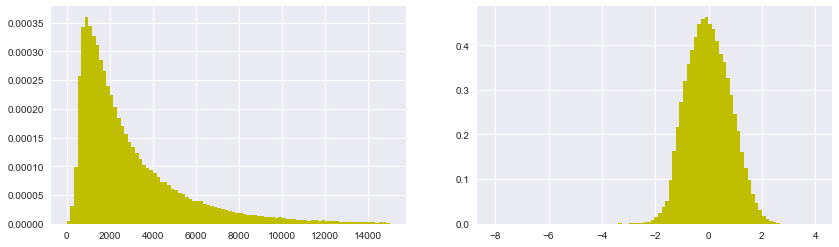

In [4]:
fig = plt.figure(figsize=(14, 4))
hist1 = fig.add_subplot(1,2,1)
hist1 = plt.hist(train_df[train_df.loss < 15000].loss, bins = 90, normed=1, color="y")

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(np.log(train_df.loss)-np.log(train_df.loss).mean(), bins = 90, normed=1, color="y")

In [5]:
shift = np.log(train_df.loss).mean()
print train_df.loss.median()
print train_df.loss.mean()

## работа с признаками

##### посмотрим, есть ли зависимость loss от id

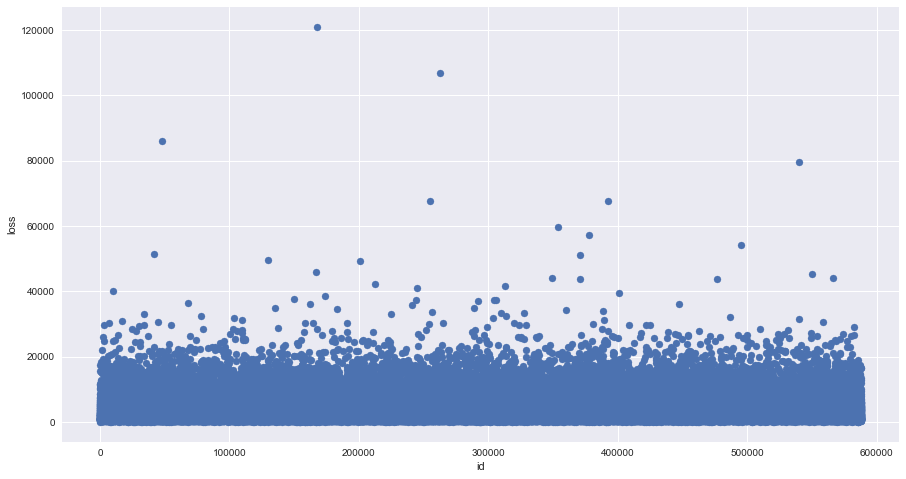

In [7]:
plt.figure(figsize=(15,8))
plt.scatter(train_df.id, train_df.loss)
plt.xlabel("id")
plt.ylabel("loss")

### выделим численные признаки

In [4]:
continuum_colomns = [x for x in train_df.columns if x.find("cont")>=0]

In [5]:
print continuum_colomns,

['cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6', 'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13', 'cont14']


### посмотрим на распределение признаков в train_df

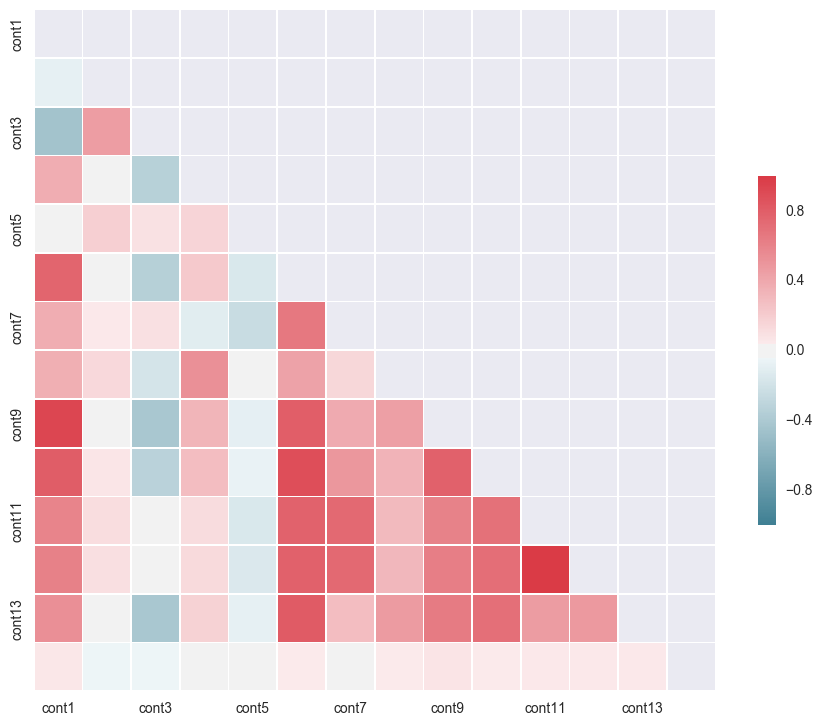

In [10]:
corr = train_df[continuum_colomns].corr()

f, ax = plt.subplots(figsize=(11, 9))

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,
            square=True, xticklabels=2, yticklabels=2,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

In [10]:
pd.DataFrame(matrix_of_corr, index=continuum_colomns, columns=continuum_colomns)

cont1     cont2     cont3     cont4     cont5     cont6     cont7  \
cont1   1.000000 -0.085180 -0.445431  0.367549 -0.025230  0.758315  0.367384   
cont2  -0.085180  1.000000  0.455861  0.038693  0.191427  0.015864  0.048187   
cont3  -0.445431  0.455861  1.000000 -0.341633  0.089417 -0.349278  0.097516   
cont4   0.367549  0.038693 -0.341633  1.000000  0.163748  0.220932 -0.115064   
cont5  -0.025230  0.191427  0.089417  0.163748  1.000000 -0.149810 -0.249344   
cont6   0.758315  0.015864 -0.349278  0.220932 -0.149810  1.000000  0.658918   
cont7   0.367384  0.048187  0.097516 -0.115064 -0.249344  0.658918  1.000000   
cont8   0.361163  0.137468 -0.185432  0.528740  0.009015  0.437437  0.142042   
cont9   0.929912 -0.032729 -0.417054  0.328961 -0.088202  0.797544  0.384343   
cont10  0.808551  0.063526 -0.325562  0.283294 -0.064967  0.883351  0.492621   
cont11  0.596090  0.116824  0.025271  0.120927 -0.151548  0.773745  0.747108   
cont12  0.614225  0.106250  0.006111  0.130453 -0.148217  0.785144  0.742712   
cont13  0.534850  0.023335 -0.418203  0.179342 -0.082915  0.815091  0.288395   
cont14  0.056688 -0.045584 -0.039592  0.017445 -0.021638  0.042178  0.022286   

           cont8     cont9    cont10    cont11    cont12    cont13    cont14  
cont1   0.361163  0.929912  0.808551  0.596090  0.614225  0.534850  0.056688  
cont2   0.137468 -0.032729  0.063526  0.116824  0.106250  0.023335 -0.045584  
cont3  -0.185432 -0.417054 -0.325562  0.025271  0.006111 -0.418203 -0.039592  
cont4   0.528740  0.328961  0.283294  0.120927  0.130453  0.179342  0.017445  
cont5   0.009015 -0.088202 -0.064967 -0.151548 -0.148217 -0.082915 -0.021638  
cont6   0.437437  0.797544  0.883351  0.773745  0.785144  0.815091  0.042178  
cont7   0.142042  0.384343  0.492621  0.747108  0.742712  0.288395  0.022286  
cont8   1.000000  0.452658  0.336588  0.302381  0.315904  0.476402  0.043539  
cont9   0.452658  1.000000  0.785697  0.608000  0.626656  0.642028  0.074154  
cont10  0.336588  0.785697  1.000000  0.702896  0.713812  0.707876  0.041808  
cont11  0.302381  0.608000  0.702896  1.000000  0.994384  0.466247  0.047293  
cont12  0.315904  0.626656  0.713812  0.994384  1.000000  0.478677  0.050267  
cont13  0.476402  0.642028  0.707876  0.466247  0.478677  1.000000  0.047543  
cont14  0.043539  0.074154  0.041808  0.047293  0.050267  0.047543  1.000000

In [35]:
for i, col_i in zip(range(14), continuum_colomns) :
    for j, col_j in zip(range(14), continuum_colomns):
        if matrix_of_corr[i, j] > 0.75 and i!=j:
            print col_i, col_j, matrix_of_corr[i,j]

cont1 cont6 0.758315316437
cont1 cont9 0.929911705762
cont1 cont10 0.808550869434
cont6 cont1 0.758315316437
cont6 cont9 0.797543518995
cont6 cont10 0.883350506849
cont6 cont11 0.773745453552
cont6 cont12 0.785143972437
cont6 cont13 0.815091076521
cont9 cont1 0.929911705762
cont9 cont6 0.797543518995
cont9 cont10 0.785696791496
cont10 cont1 0.808550869434
cont10 cont6 0.883350506849
cont10 cont9 0.785696791496
cont11 cont6 0.773745453552
cont11 cont12 0.994384110022
cont12 cont6 0.785143972437
cont12 cont11 0.994384110022
cont13 cont6 0.815091076521


кандидаты на коррелирование

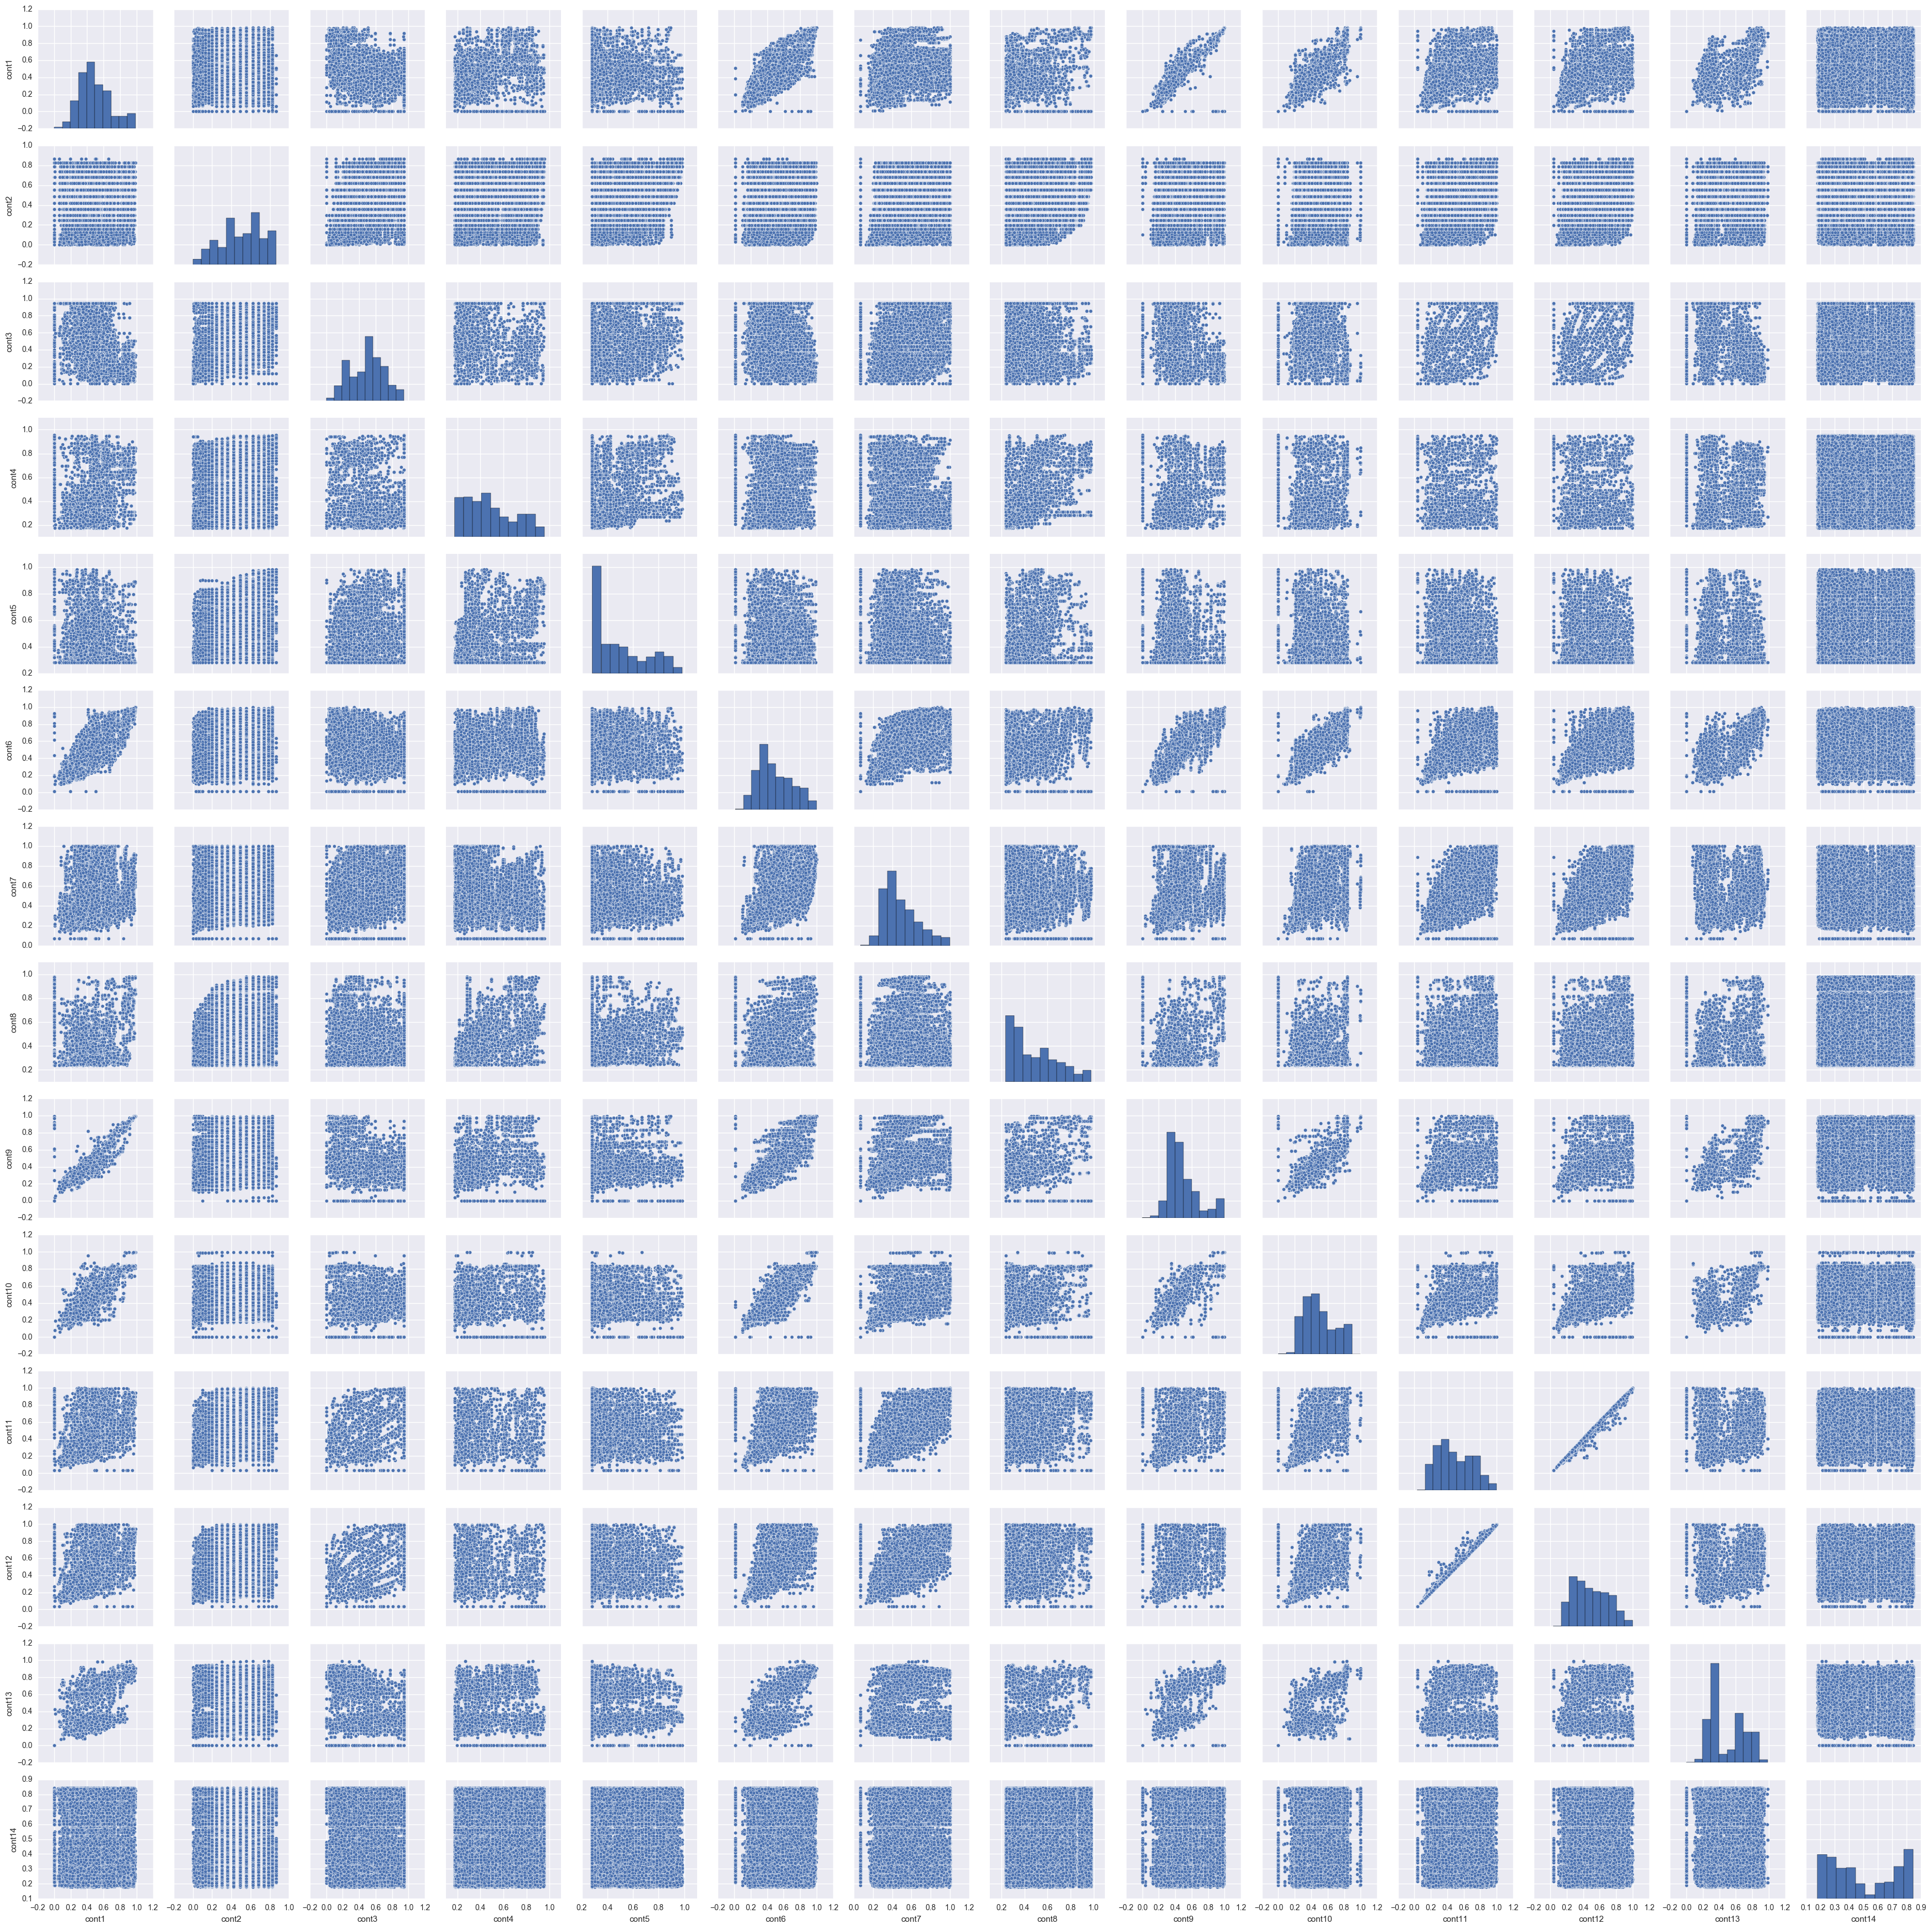

In [10]:
sns.pairplot(train_df[continuum_colomns])

### сравним распределения численных признаков в train_df и test_df

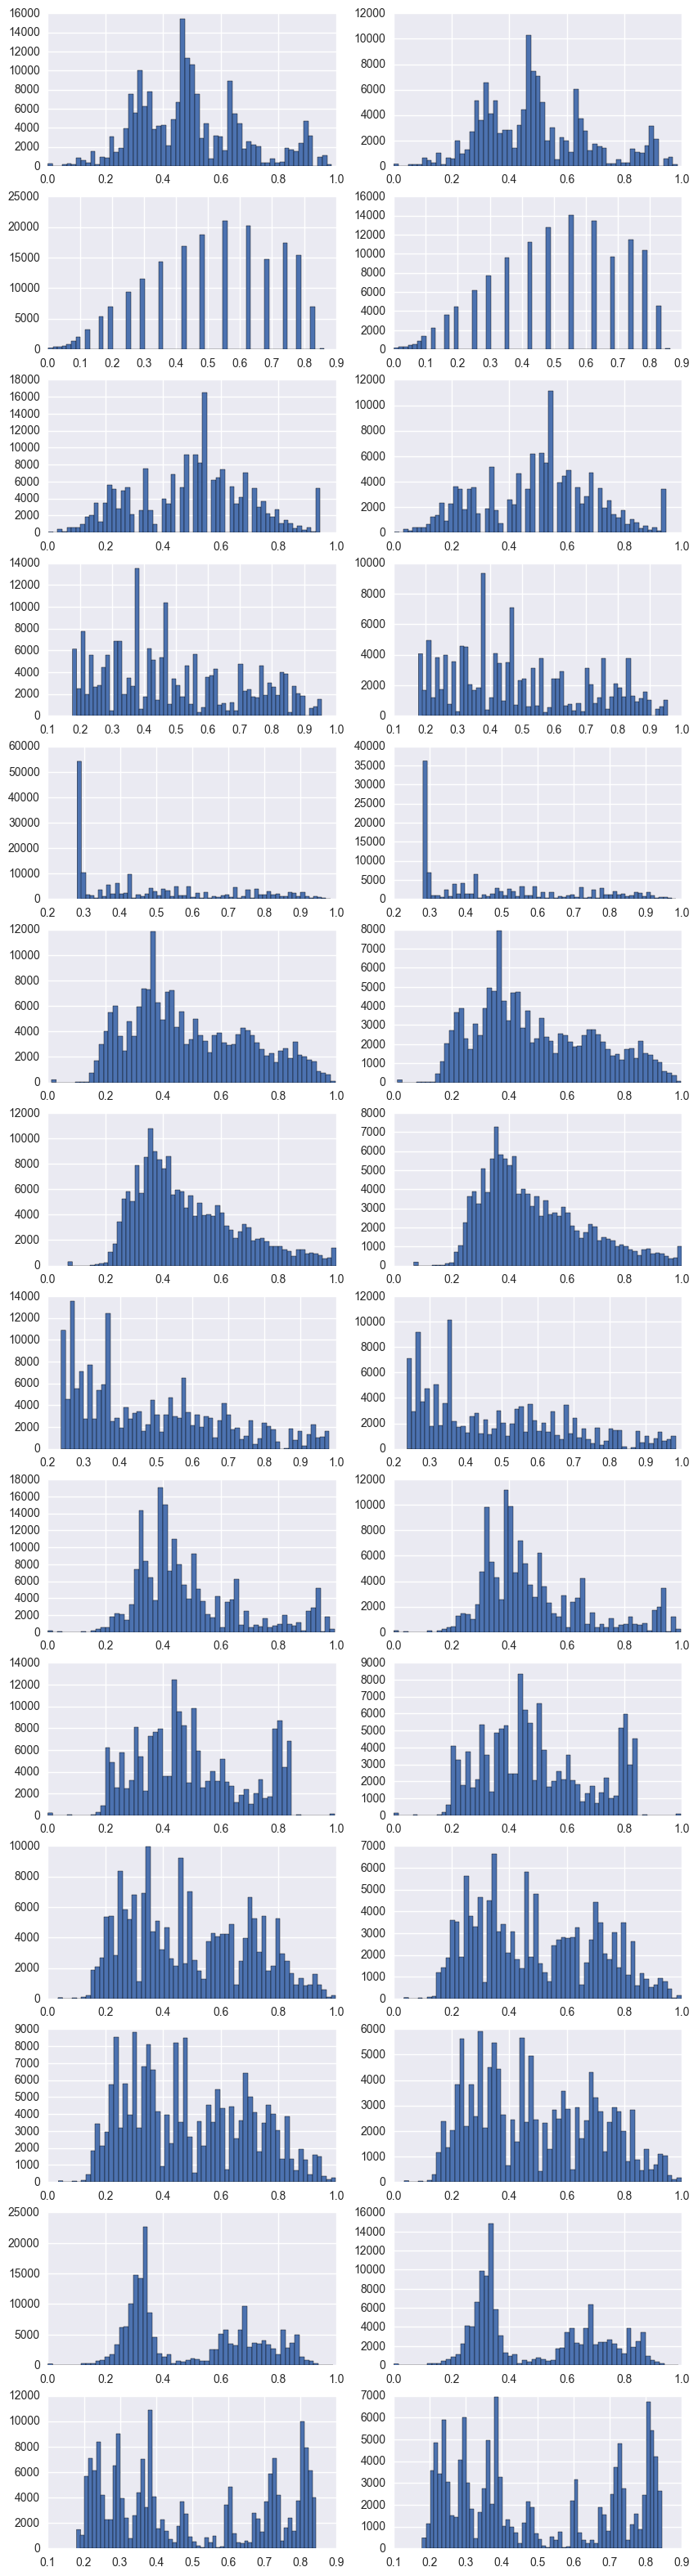

In [9]:
fig = plt.figure(figsize=(10,40))

i=1
for cont in continuum_colomns:
    hist = fig.add_subplot(14,2,i )
    hist = plt.hist(train_df[cont], bins=60)
    
    hist = fig.add_subplot(14,2,i+1)
    hist = plt.hist(test_df[cont], bins=60)
    i+=2

### Видим, что данные распределены в train_df и test_df одинаково

начнем анализировать данные более подробно.
## cont1

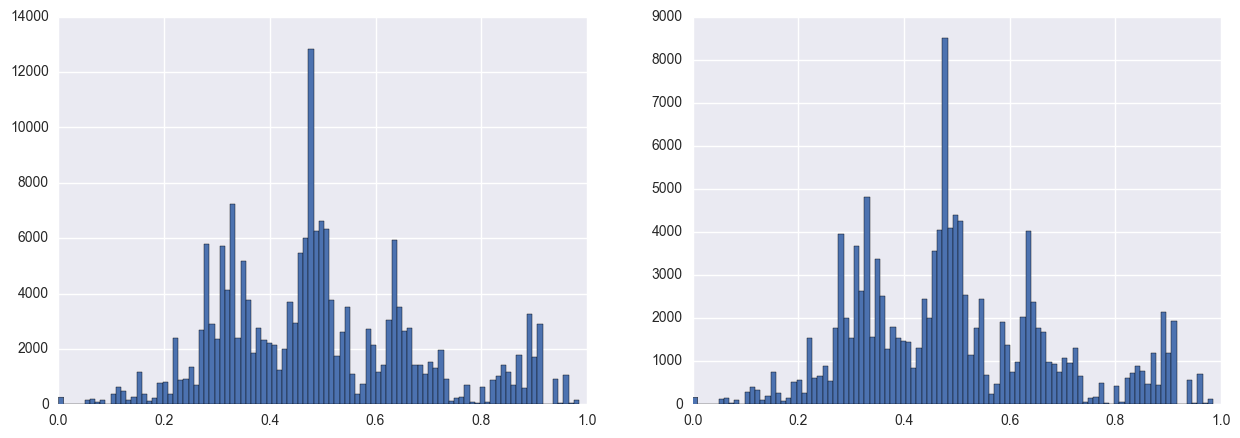

In [11]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont1'], bins=100)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont1'], bins=100)

видим чёткие кластеры и в train_df и в test_df. Кластеризуем с помощью kNN

In [7]:
clf = KMeans(n_clusters=7, n_jobs=-1, precompute_distances=True, verbose=0)
clf.fit(train_df.cont1.reshape(-1, 1))
train_df['cont1_clusters'] = clf.labels_
test_df['cont1_clusters'] = clf.predict(test_df.cont1.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

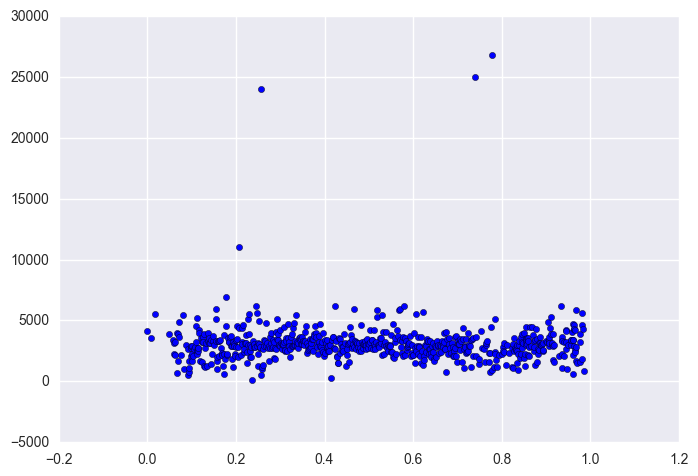

In [8]:
tmp = pd.DataFrame(train_df.groupby('cont1').loss.mean())
plt.scatter(tmp.index, tmp.loss)

### cont2

#### train

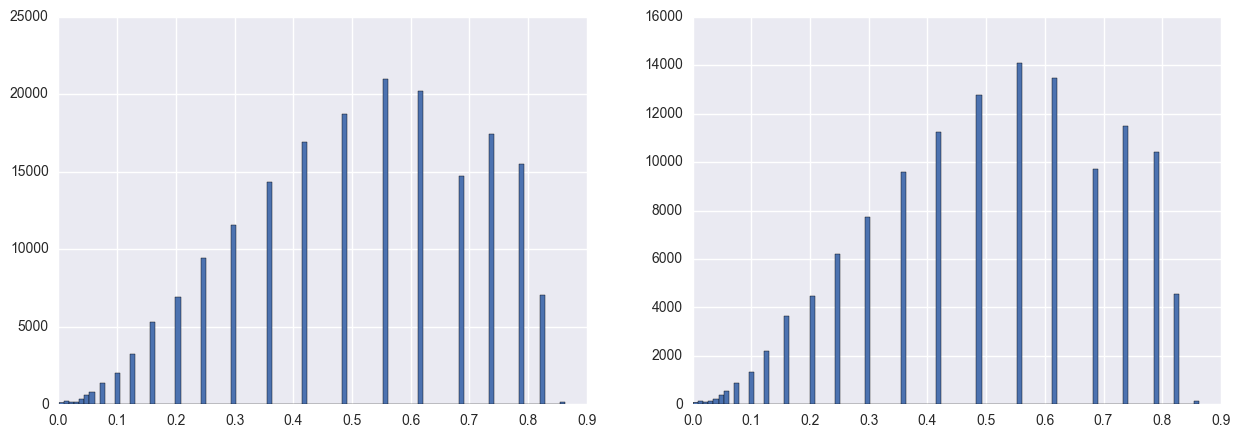

In [21]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont2'], bins=100)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont2'], bins=100)

тоже видны 2 (или 3) кластера

33 разных категории и в train_df и в test_df. Скорее всего, это категориальный признак

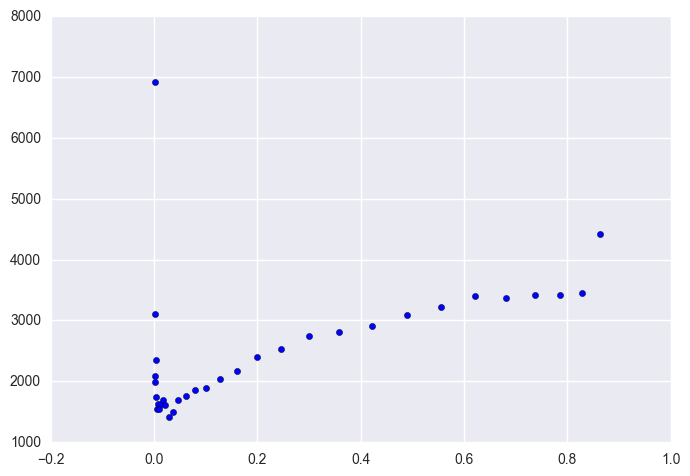

In [24]:
tmp = pd.DataFrame(train_df.groupby('cont2').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [9]:
train_df['cont2_small_anom'] = train_df['cont2'] < 0.1
test_df['cont2_small_anom'] = test_df['cont2'] < 0.1

train_df['cont2_middle'] = ((train_df['cont2'] >= 0.1) & (train_df['cont2'] < 0.7))
test_df['cont2_middle'] = ((test_df['cont2'] >= 0.1) & (test_df['cont2'] < 0.7))

train_df['cont2_max_value'] = (train_df['cont2'] == train_df.cont2.unique().max())
test_df['cont2_max_value'] = (test_df['cont2'] == test_df.cont2.unique().max())

train_df['cont2_min_value'] = ((train_df['cont2'] >= 0.00150) & (train_df['cont2'] < 0.00155))
test_df['cont2_min_value'] = ((test_df['cont2'] >= 0.001500) & (test_df['cont2'] < 0.00155))

In [37]:
train_df.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9       ...          cont11  \
0   1    A    B    A    B    A    A    A    A    B       ...        0.569745   
1   2    A    B    A    A    A    A    A    A    B       ...        0.338312   
2   5    A    B    A    A    B    A    A    A    B       ...        0.381398   
3  10    B    B    A    B    A    A    A    A    B       ...        0.327915   
4  11    A    B    A    B    A    A    A    A    B       ...        0.204687   

     cont12    cont13    cont14     loss cont1_clusters cont2_small_anom  \
0  0.594646  0.822493  0.714843  2213.18              3            False   
1  0.366307  0.611431  0.304496  1283.60              0            False   
2  0.373424  0.195709  0.774425  3005.09              0            False   
3  0.321570  0.605077  0.602642   939.85              0            False   
4  0.202213  0.246011  0.432606  2763.85              0            False   

  cont2_middle cont2_max_value cont2_min_value  
0         True           False           False  
1        False           False           False  
2         True           False           False  
3         True           False           False  
4         True           False           False  

[5 rows x 137 columns]

### cont3

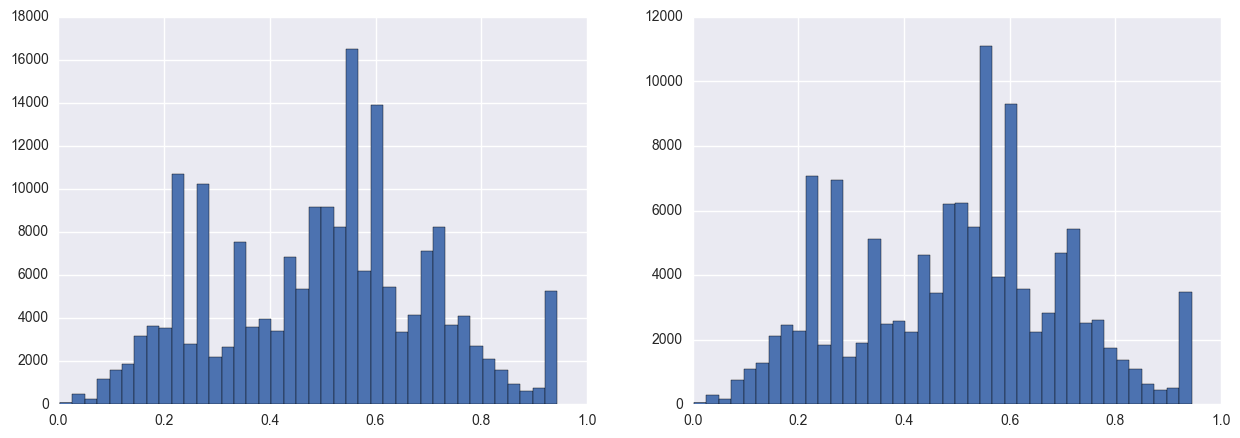

In [64]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont3'], bins=40)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont3'], bins=40)

In [51]:
print(train_df.cont3.nunique())
print(test_df.cont3.nunique())

76

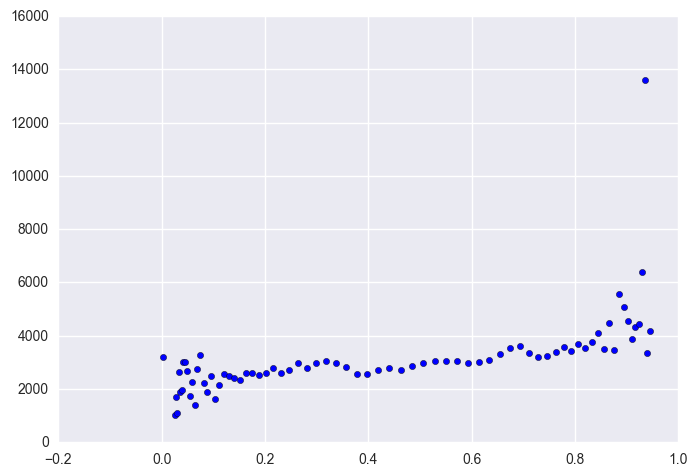

In [39]:
tmp = pd.DataFrame(train_df.groupby('cont3').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [51]:
pd.DataFrame(train_df.groupby('cont3').loss.mean()).sort(ascending=False).head()

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(....) is deprecated, use sort_index(.....)
  if __name__ == '__main__':


loss
cont3                 
0.944251   4193.644495
0.939453   3338.014398
0.934270  13614.173333
0.928678   6386.502778
0.922649   4437.014762

очень резкие колебания, особенно в конце, очень важный признак, принадлежит ли к концу или к началу

In [13]:
train_df['cont3_max_value'] = ((train_df.cont3 >= 0.939453) & (train_df.cont3 < 0.94))
test_df['cont3_max_value'] = ((test_df.cont3 >= 0.939453) & (test_df.cont3 < 0.94))

train_df['cont3_small'] = train_df.cont3 < 0.15
train_df['cont3_big'] = train_df.cont3 > 0.82

test_df['cont3_small'] = test_df.cont3 < 0.15
test_df['cont3_big'] = test_df.cont3 > 0.82

### cont4

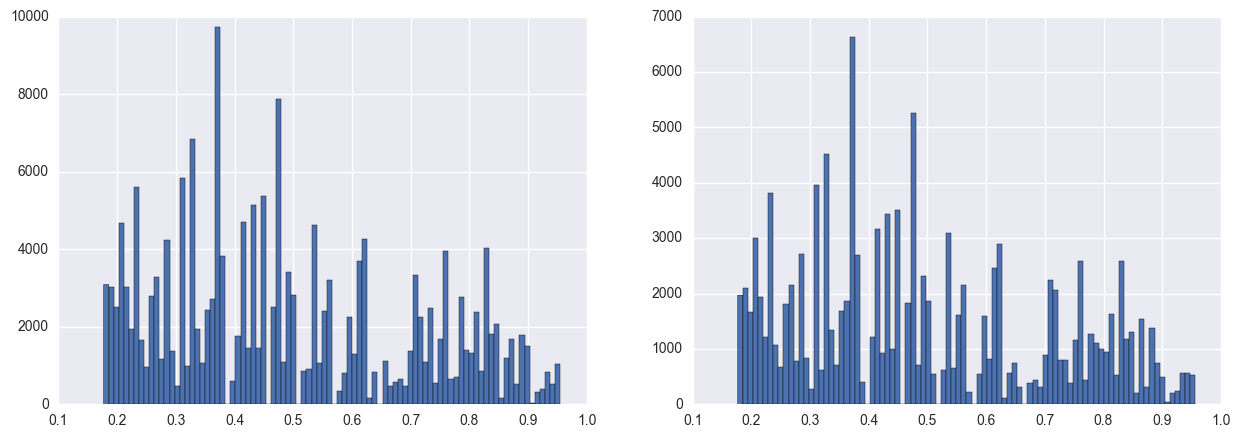

In [60]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont4'], bins=90)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont4'], bins=90)

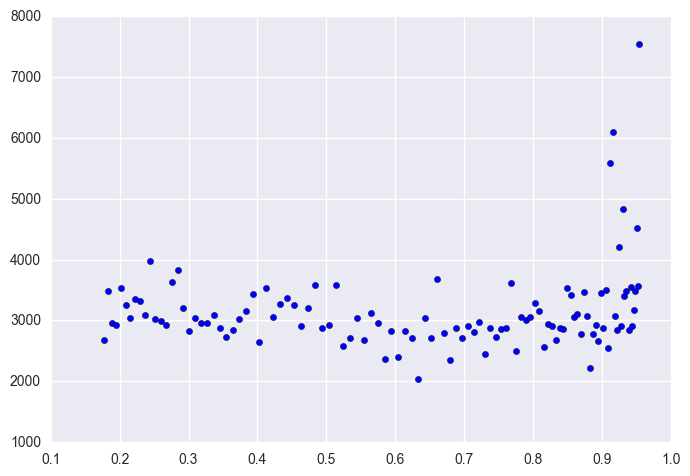

In [17]:
tmp = pd.DataFrame(train_df.groupby('cont4').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [16]:
clf = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont4.reshape(-1, 1))

train_df['cont4_clusters'] = clf.labels_
test_df['cont4_clusters'] = clf.predict(test_df.cont4.reshape(-1,1))

train_df['cont4_big'] = train_df.cont4 > 0.9
test_df['cont4_big'] =  test_df.cont4 > 0.9

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

## cont5

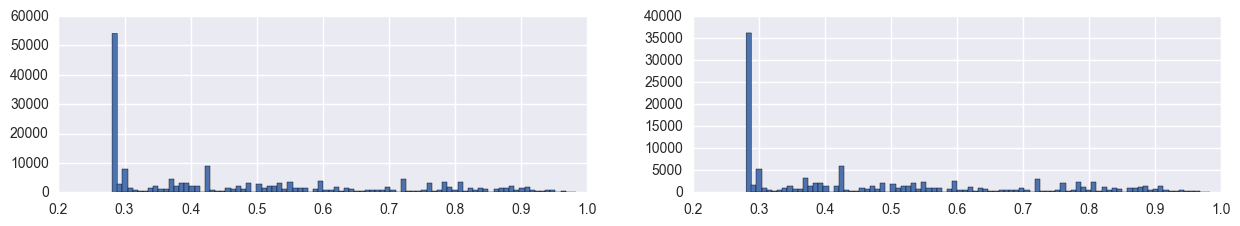

In [69]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(2,2,1 )
hist = plt.hist(train_df['cont5'], bins=90)

hist2 = fig.add_subplot(2,2,2)
hist2 = plt.hist(test_df['cont5'], bins=90)

In [21]:
clf = KMeans(n_clusters=5, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont5.reshape(-1, 1))

train_df['cont5_clusters'] = clf.labels_
test_df['cont5_clusters'] = clf.predict(test_df.cont5.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

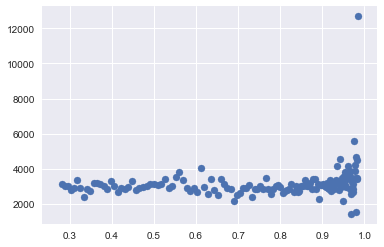

In [8]:
tmp = pd.DataFrame(train_df.groupby('cont5').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [23]:
train_df['cont5_big_anom'] = train_df.cont5 > 0.93
test_df['cont5_big_anom'] = test_df.cont5 > 0.93

### cont6

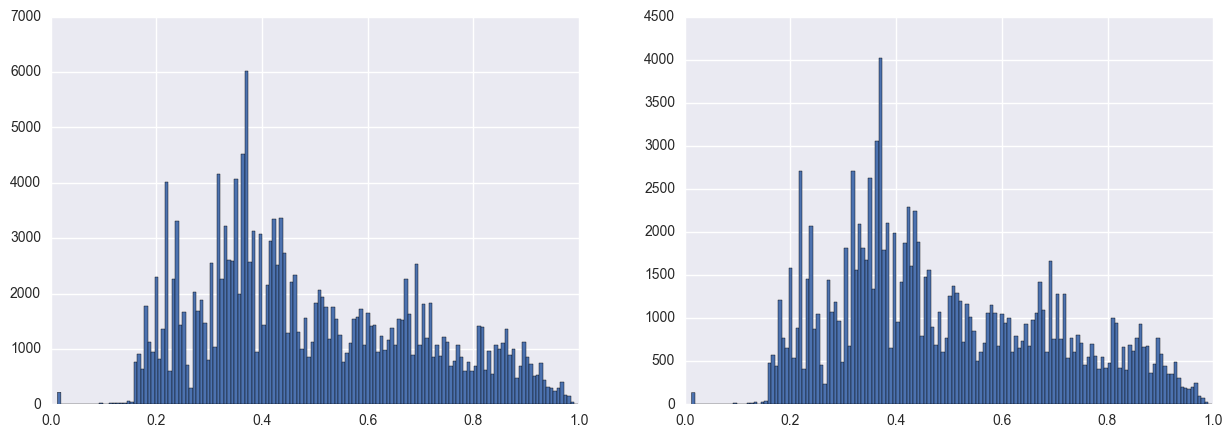

In [75]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont6'], bins=150)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont6'], bins=150)

In [24]:
clf = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont6.reshape(-1, 1))

train_df['cont6_clusters'] = clf.labels_
test_df['cont6_clusters'] = clf.predict(test_df.cont6.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

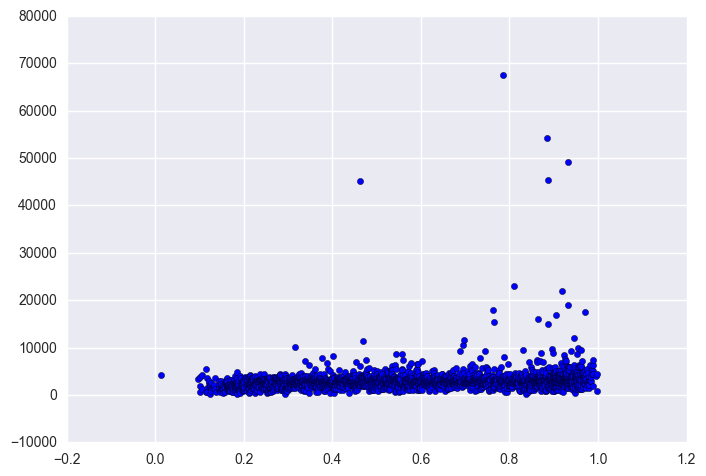

In [76]:
tmp = pd.DataFrame(train_df.groupby('cont6').loss.mean())
plt.scatter(tmp.index, tmp.loss)

очень странные выбросы, нужно их обособить. И особенность при cont6<0.15 (примерно)

### cont 7

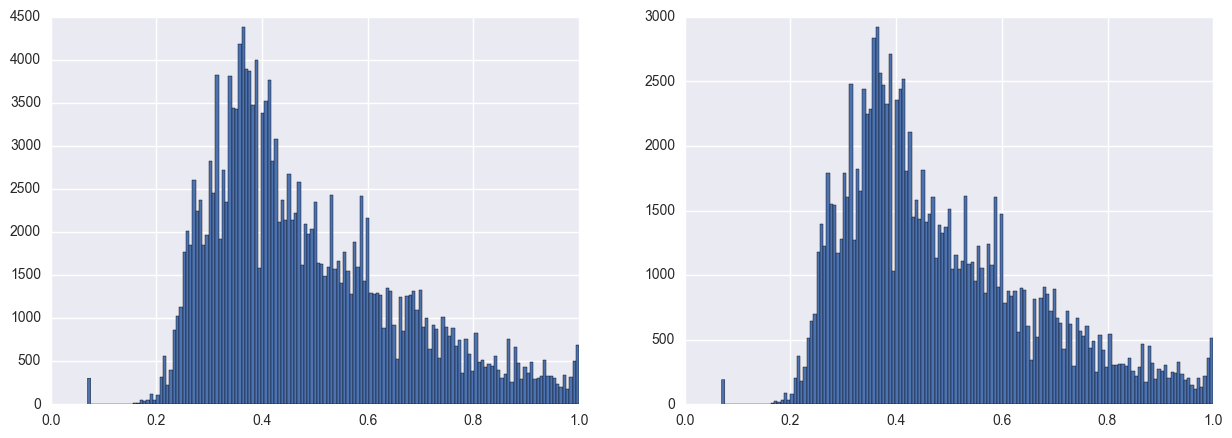

In [5]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont7'], bins=150)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont7'], bins=150)

стоит попробовать разбить на несколько кластеров (большой пропуск значений посередине и хвост справа)

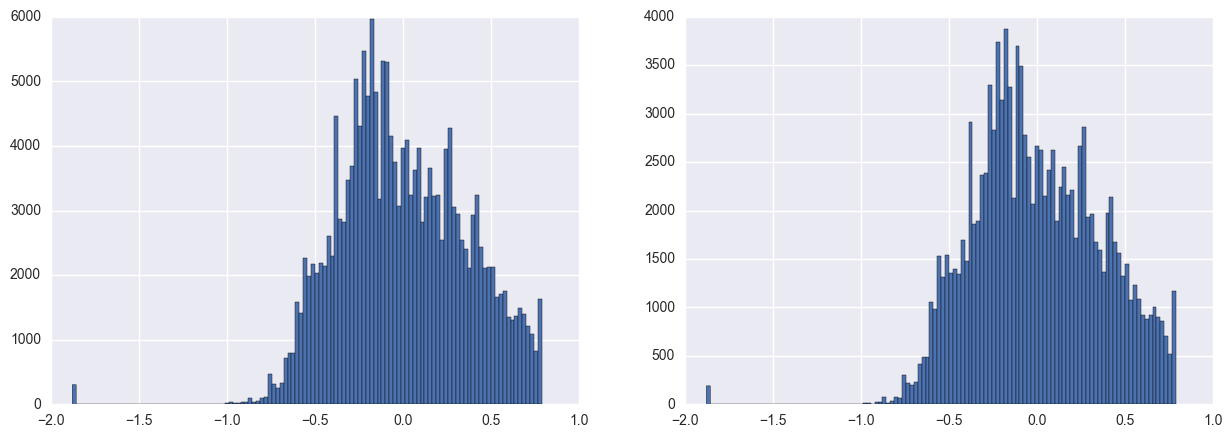

In [60]:
fig = plt.figure(figsize=(15,5))

shift = np.log(train_df['cont7']).mean()

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(np.log(train_df['cont7'])-shift, bins=120)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(np.log(test_df['cont7'])-shift, bins=120)

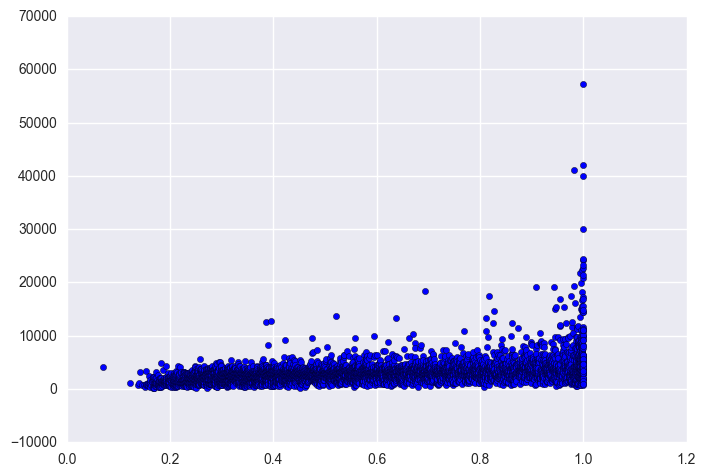

In [80]:
tmp = pd.DataFrame(train_df.groupby('cont7').loss.mean())
plt.scatter(tmp.index, tmp.loss)

аналогичная cont6 странность при небольших cont7

In [26]:
train_df['cont7_small'] = train_df.cont7 < 0.1
test_df['cont7_small'] = test_df.cont7 < 0.1

train_df['cont7_big'] = train_df.cont7 > 0.93
test_df['cont7_big'] = train_df.cont7 > 0.93

### cont8

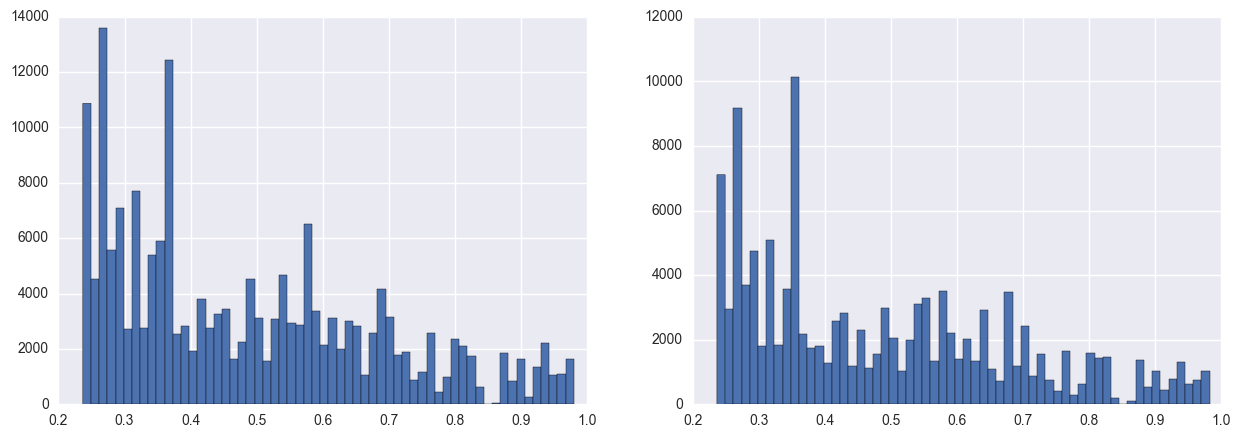

In [61]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont8'], bins=60)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont8'], bins=60)

есть странный хвост

надо кластеризовать на несколько классов, как в cont1

In [27]:
clf = KMeans(n_clusters=8, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont8.reshape(-1, 1))

train_df['cont8_clusters'] = clf.labels_
test_df['cont8_clusters'] = clf.predict(test_df.cont8.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=-1, precompute_distances=True,
    random_state=None, tol=0.0001, verbose=0)

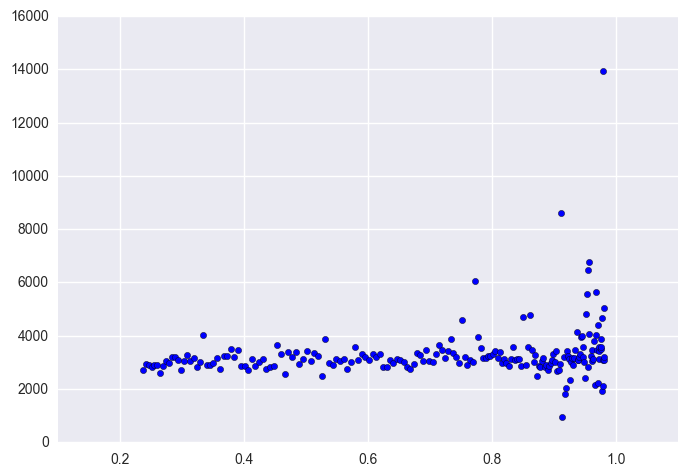

In [84]:
tmp = pd.DataFrame(train_df.groupby('cont8').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [89]:
tmp.sort('loss', ascending=False).head()

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


loss
cont8                
0.97774  13934.320000
0.91076   8608.248750
0.95642   6758.050000
0.95438   6474.107143
0.77250   6061.112289

In [29]:
train_df['cont8_big'] = ((train_df.cont8 >= 0.974970) & (train_df.cont8 < 0.97498))
test_df['cont8_big'] = ((test_df.cont8 >= 0.974970) & (test_df.cont8 < 0.97498))

### cont9

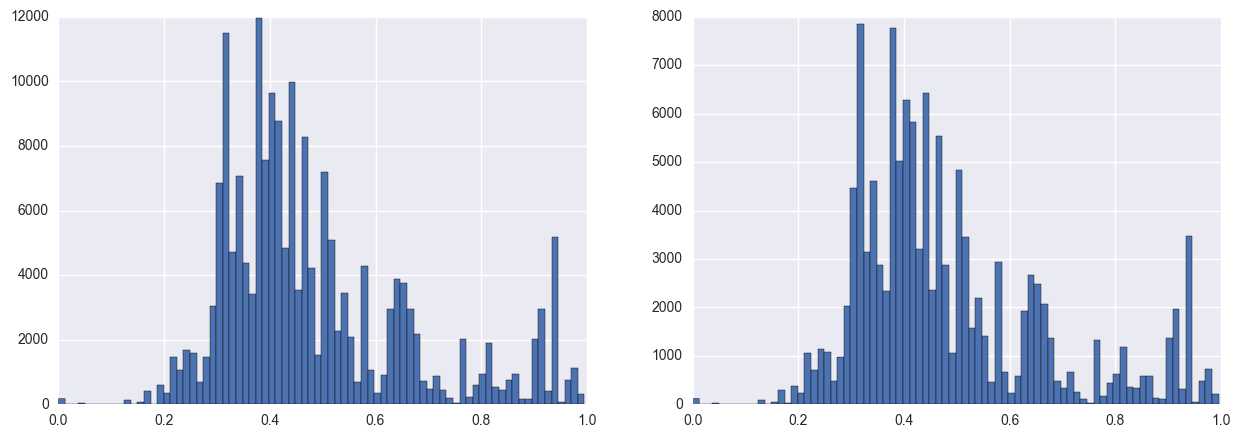

In [63]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont9'], bins=80)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont9'], bins=80)

опять несколкьо кластеров, которые хорошо отделяются по гистограмме

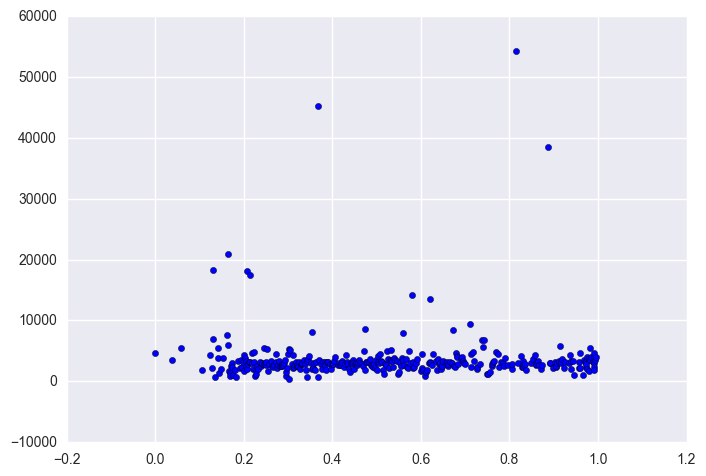

In [75]:
tmp = pd.DataFrame(train_df.groupby('cont9').loss.mean())
plt.scatter(tmp.index, tmp.loss)

In [31]:
clf = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont9.reshape(-1, 1))

train_df['cont9_clusters'] = clf.labels_
test_df['cont9_clusters'] = clf.predict(test_df.cont9.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


## cont10

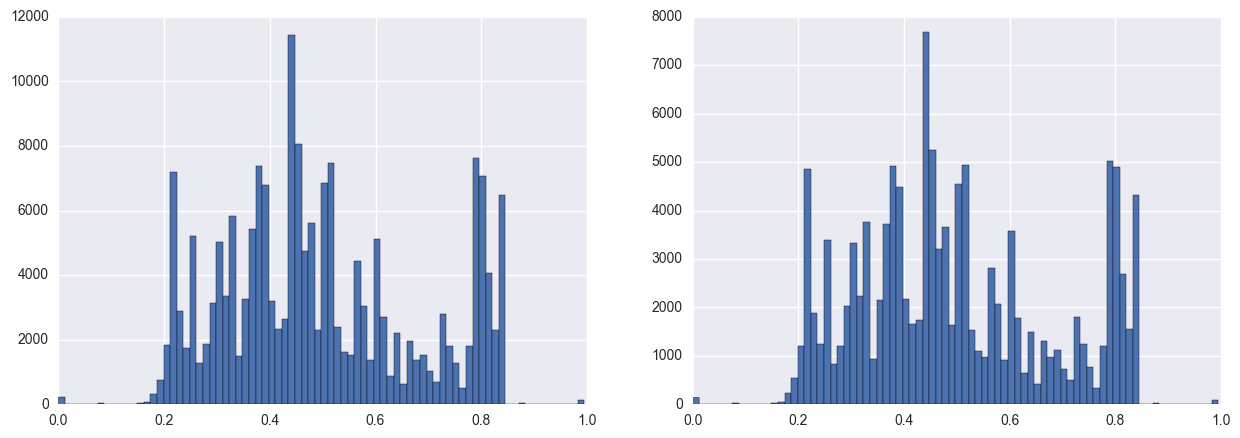

In [98]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont10'], bins=80)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont10'], bins=80)

In [32]:
clf = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont10.reshape(-1, 1))

train_df['cont10_clusters'] = clf.labels_
test_df['cont10_clusters'] = clf.predict(test_df.cont10.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


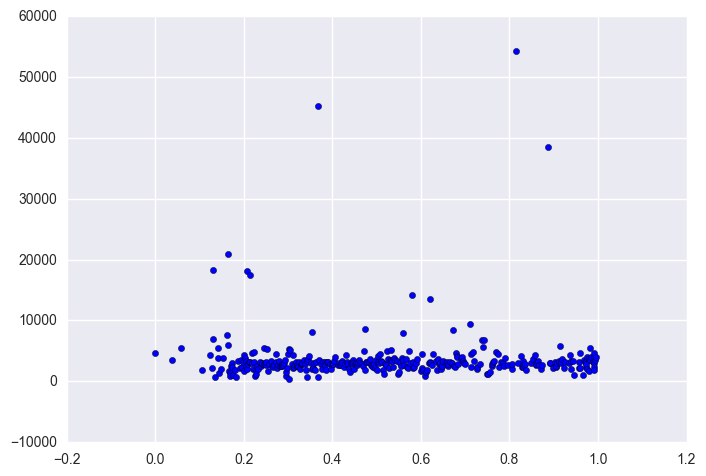

In [100]:
tmp = pd.DataFrame(train_df.groupby('cont9').loss.mean())
plt.scatter(tmp.index, tmp.loss)

### cont 13

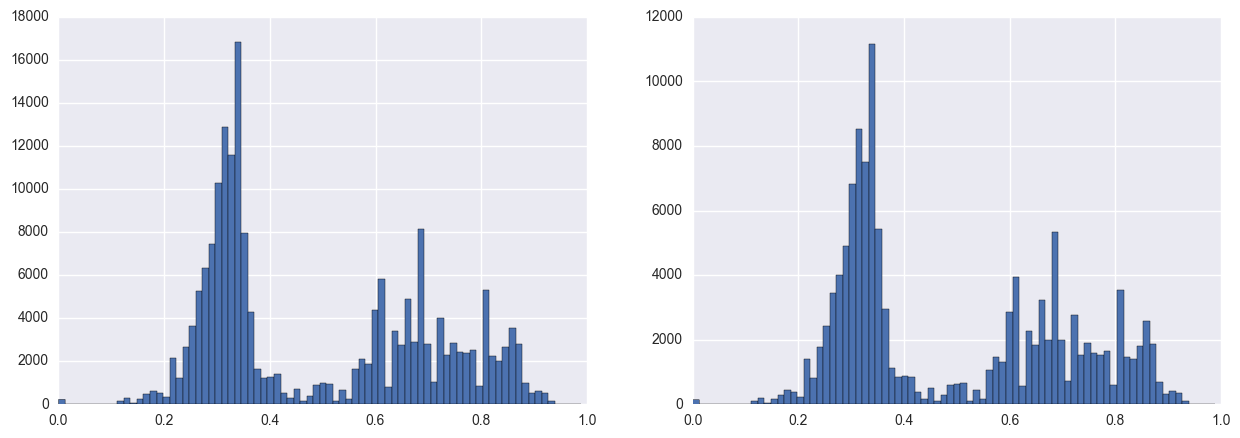

In [80]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont13'], bins=80)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont13'], bins=80)

In [33]:
train_df['cont13_small_x'] = train_df.cont13 < 0.1
test_df['cont13_small_x'] = test_df.cont13 < 0.1

train_df['cont13_small'] = ((train_df['cont13'] >= 0.1) & (train_df['cont13'] < 0.21))
test_df['cont13_small'] = ((test_df['cont13'] >= 0.1) & (train_df['cont13'] < 0.21))

train_df['cont13_middle'] = ((train_df['cont13'] >= 0.21) & (train_df['cont13'] < 0.4))
test_df['cont13_middle'] = ((test_df['cont13'] >= 0.21) & (test_df['cont13'] < 0.4))

train_df['cont13_middle_x'] = ((train_df['cont13'] >= 0.4) & (train_df['cont13'] < 0.55))
test_df['cont13_middle_x'] = ((test_df['cont13'] >= 0.4) & (test_df['cont13'] < 0.55))

train_df['cont13_big'] = ((train_df['cont13'] >= 0.55) & (train_df['cont13'] < 0.7))
test_df['cont13_big'] = ((test_df['cont13'] >= 0.55) & (test_df['cont13'] < 0.7))

train_df['cont13_big_x'] = ((train_df['cont13'] >= 0.7) & (train_df['cont13'] < 0.8))
test_df['cont13_big_x'] = ((test_df['cont13'] >= 0.7) & (test_df['cont13'] < 0.8))

train_df['cont13_big_2x'] = train_df['cont13'] >= 0.8
test_df['cont13_big_2x'] = test_df['cont13'] >= 0.8

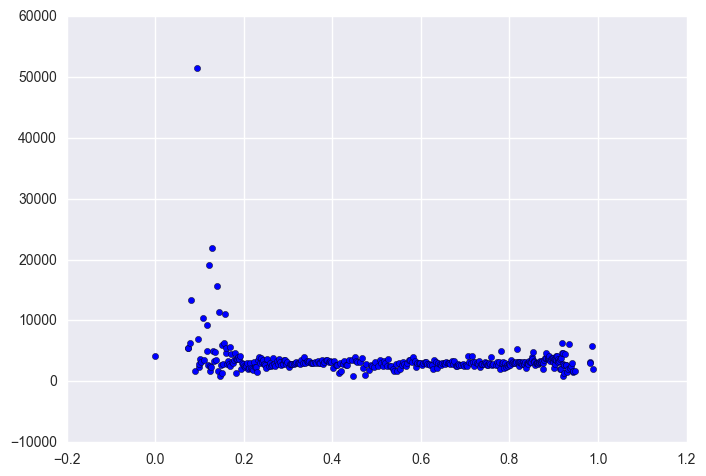

In [103]:
tmp = pd.DataFrame(train_df.groupby('cont13').loss.mean())
plt.scatter(tmp.index, tmp.loss)

### cont 14

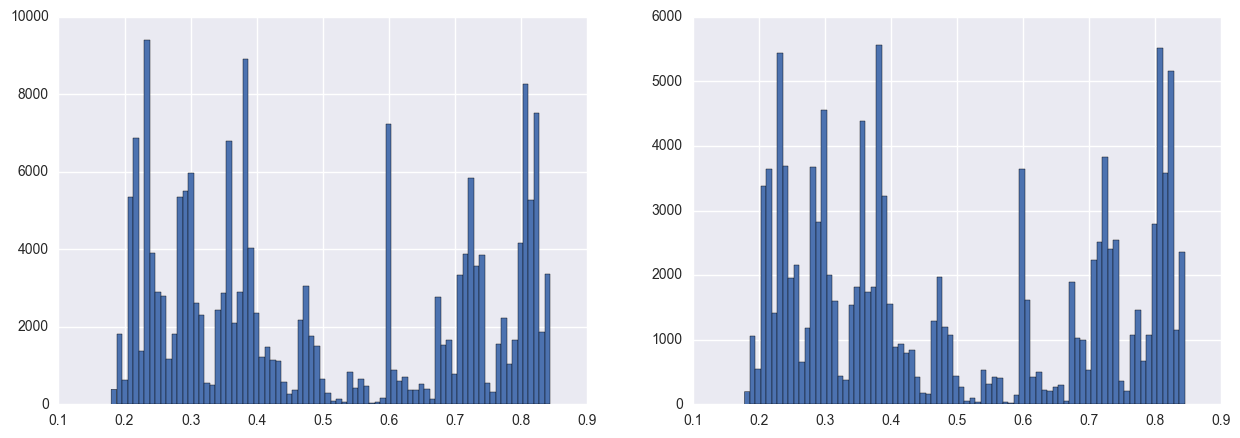

In [104]:
fig = plt.figure(figsize=(15,5))

hist = fig.add_subplot(1,2,1 )
hist = plt.hist(train_df['cont14'], bins=80)

hist2 = fig.add_subplot(1,2,2)
hist2 = plt.hist(test_df['cont14'], bins=80)

In [34]:
clf = KMeans(n_clusters=10, n_jobs=-1, precompute_distances=True)
clf.fit(train_df.cont14.reshape(-1, 1))

train_df['cont14_clusters'] = clf.labels_
test_df['cont14_clusters'] = clf.predict(test_df.cont14.reshape(-1,1))

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  from ipykernel import kernelapp as app
/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [65]:
train_df.head()

id cat1 cat2 cat3 cat4 cat5 cat6 cat7 cat8 cat9       ...        \
0   1    A    B    A    B    A    A    A    A    B       ...         
1   2    A    B    A    A    A    A    A    A    B       ...         
2   5    A    B    A    A    B    A    A    A    B       ...         
3  10    B    B    A    B    A    A    A    A    B       ...         
4  11    A    B    A    B    A    A    A    A    B       ...         

  cont9_clusters cont10_clusters cont13_small_x cont13_small cont13_middle  \
0              0               2          False        False         False   
1              1               5          False        False         False   
2              6               1          False         True         False   
3              8               5          False        False         False   
4              6               4          False        False          True   

  cont13_middle_x cont_13_big cont13_big_x cont13_big_2x cont14_clusters  
0           False       False        False          True               1  
1           False        True        False         False               7  
2           False       False        False         False               3  
3           False        True        False         False               4  
4           False       False        False         False               9  

[5 rows x 159 columns]

### categorical features -> dummies

In [35]:
y = train_df.loss
train_df.drop('loss', axis=1, inplace=True)
print train_df.shape
print test_df.shape

(188318, 158)
(125546, 158)


In [36]:
tmp_concat = pd.concat([train_df, test_df], axis=0)

In [38]:
categorical_col =  train_df.columns
categorical_col = categorical_col.drop(continuum_colomns)
categorical_col = categorical_col.drop('id')

In [39]:
tmp_dummies = pd.get_dummies(tmp_concat[categorical_col], drop_first=True)

tmp_train_dummies = tmp_dummies[:188318]
tmp_test_dummies = tmp_dummies[188318:]

tmp_train = train_df.drop(categorical_col, axis=1)
tmp_test = test_df.drop(categorical_col, axis=1)

In [41]:
train_df = pd.concat([tmp_train, tmp_train_dummies], axis=1)
test_df = pd.concat([tmp_test, tmp_test_dummies], axis=1)

In [42]:
print train_df.shape
print test_df.shape

(188318, 1102)
(125546, 1102)


In [43]:
train_df.to_csv("train_with_extra_feat.csv", columns=train_df.columns)
test_df.to_csv("test_with_extra_feat.csv", columns=test_df.columns)